In [6]:
# Texton map

import numpy as np
from typing import List, Tuple
from numpy import sqrt, pi, reshape, sin, cos
import matplotlib.pyplot as plt
import cv2


def get_2d_gaussian(
		grid: [List[List[float]]], sigma, elong_factor: float = 1
) -> [List[List[float]]]:
	"""
	Calculates 2d gaussian using function defn. at each point (x, y) in grid
	"""
	x, y = grid[0], grid[1]

	sigma_y = sigma
	sigma_x = elong_factor * sigma_y

	num = np.exp(-0.5 * (x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2))
	denom = np.sqrt(2 * pi * sigma_x * sigma_y)

	return num / denom

def get_dog_filter_bank(
		size: int = 7, sigma_scales: Tuple = (1, np.sqrt(2)), angles: int = 16
) ->  List[List[List[float]]]:
	"""

	"""
	sobel_x = np.array([[+1, 0, -1], [+2, 0, -2], [+1, 0, -1]])

	bound = (size - 1) / 2
	spread = np.linspace(-bound, bound, size)
	x, y = np.meshgrid(spread, spread)
	pts = [x.flatten(), y.flatten()]

	center = (int(size / 2), int(size / 2))
	filter_shape = (size, size)

	DoGs = []
	for sigma in sigma_scales:
		g = get_2d_gaussian(pts, sigma)
		g_2d = reshape(g, filter_shape)
		g_convolved = cv2.filter2D(src=g_2d, ddepth=-1, kernel=sobel_x)

		for i in range(angles):
			angle = i * 360 / angles
			r_mat = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
			dog_filter = cv2.warpAffine(src=g_convolved, M=r_mat, dsize=filter_shape)
			DoGs.append(dog_filter)

	# Visualization
	# for i in range(len(DoGs)):
	# 	plt.subplot(2, 16, i + 1)
	# 	plt.axis('off')
	# 	plt.imshow(DoGs[i], cmap='gray')

	return DoGs

def get_gabor_filter_bank() -> [List[List[float]]]:
	def _gabor(sigma, theta, Lambda, psi, gamma):
		"""Gabor feature extraction."""
		sigma_x = sigma
		sigma_y = float(sigma) / gamma

		nstds = 3  # Number of standard deviation sigma
		xmax = max(abs(nstds * sigma_x * np.cos(theta)),
				   abs(nstds * sigma_y * np.sin(theta)))
		xmax = np.ceil(max(1, xmax))

		ymax = max(abs(nstds * sigma_x * np.sin(theta)),
				   abs(nstds * sigma_y * np.cos(theta)))
		ymax = np.ceil(max(1, ymax))

		xmin = -xmax
		ymin = -ymax

		(x, y) = np.meshgrid(np.arange(xmin, xmax + 1),
							 np.arange(ymin, ymax + 1))

		# Rotation
		x_theta = x * np.cos(theta) + y * np.sin(theta)
		y_theta = -x * np.sin(theta) + y * np.cos(theta)

		gb = np.exp(-.5 * (
					x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(
			2 * np.pi / Lambda * x_theta + psi)
		return gb

	gamma = 1
	sigma_scales = [18, 24, 30, 36, 42]
	angles = 8

	Lambda = 30
	psi = 30

	gabor_bank = []
	for sigma in sigma_scales:
		for i in range(angles):
			theta = i * np.pi / angles
			gb = _gabor(sigma, theta, Lambda, psi, gamma)
			gabor_bank.append(gb)

	return gabor_bank


def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def get_lm_filter_bank():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    LM_bank = []
    for i in range(48):
        LM_bank.append(L[:,:,i])

    return LM_bank

In [7]:
D = get_dog_filter_bank()
L = get_lm_filter_bank()
G = get_gabor_filter_bank()

In [8]:
len(L)

48

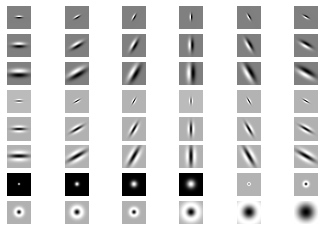

In [10]:
for i in range(len(L)):
    plt.subplot(8, 6, i + 1)
    plt.axis('off')
    plt.imshow(L[i], cmap='gray')
    
# for i in range(48):
#     plt.subplot(8,6,i+1)
#     plt.axis('off')
#     plt.imshow(L[:,:,i], cmap = 'gray')

In [18]:
# from sklearn.cluster import KMeans
import cv2

img = cv2.imread("/home/radha/Downloads/test_samples/test1.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_channels = []
for bank in [D, L, G]:
    for filt in bank:
        img_convolved = cv2.filter2D(src=img_gray, ddepth=-1, kernel=filt)
        img_channels.append(img_convolved)
    
img_channels = np.array(img_channels)
img_shape = np.array(img_channels).shape
pixels = np.dot(img_shape[1], img_shape[2])

img = img_channels.swapaxes(0, 2)
img = img.reshape(pixels, img_shape[0])

In [19]:
img

array([[  0,   1,   0, ...,   0, 255, 102],
       [  0,   0,   0, ..., 207,  14,  42],
       [  0,   0,   0, ..., 255,   0,   0],
       ...,
       [  0,  96, 135, ..., 255,   0,   0],
       [  0,  81, 114, ..., 255,   0,   0],
       [  0,   1,   0, ..., 255,   0,   0]], dtype=uint8)

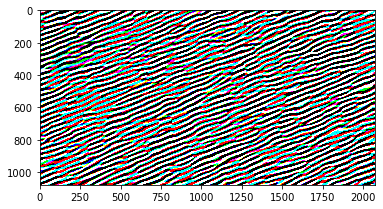

In [32]:
import matplotlib.pyplot as plt
plt.imshow(image_channels[100])

In [5]:
import numpy as np
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
# a.c_


# x.swapaxes(0,2).reshape(16,3).reshape(8,2,3).swapaxes(0,2)

In [6]:
a

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

In [40]:
len(a)
s = a.shape
# np.dot(a.shape[0], a.shape[1], a.shape[2])
# np.dot(s[1], s[2])
s

(4, 3, 3)

In [46]:
np.max(a)

9

In [34]:
# b = a.swapaxes(0, 2)

In [38]:
depth = len(a)
s = a.shape
pixels = np.dot(s[1], s[2])

c = a.reshape(depth, pixels)
c

array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [39]:
c = c.transpose()
c

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4],
       [5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [8, 8, 8, 8],
       [9, 9, 9, 9]])

In [26]:
y_km = np.array([52, 43, 43, ..., 38, 38, 38])

texton_image = y_km.reshape([466, 357])
# print("KM shape", km.shape)

plt.imshow(texton_image)


ValueError: cannot reshape array of size 7 into shape (466,357)

In [ ]:
img = cv2.imread("/home/radha/Downloads/test_samples/test1.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gray = np.array(img_gray)
img_shape = img_gray.shape
pixels = np.dot(img_shape[1], img_shape[2])

img = img_channels.swapaxes(0, 2)
img = img.reshape(pixels, img_shape[0])

km = KMeans(n_clusters=64, n_init=2)
y_km = km.fit_predict(img)
texton_image = y_km.reshape([img_shape[1], img_shape[2]])
# print("KM shape", km.shape)

plt.imshow(texton_image)
plt.imsave("/home/radha/text.jpg", texton_image)
# plt.pause(30)

import pprint
pprint.pprint(y_km)

In [142]:
import numpy as np
from typing import List



def get_half_disks(size: int, radius: int) -> [List[List[float]]]:

    bound = (size - 1) / 2
    spread_x = np.linspace(-bound, bound, size)
    spread_y = np.linspace(-bound, bound, size)

    x, y = np.meshgrid(spread_x, spread_y)
    pts = [x.flatten(), y.flatten()]

    x, y = pts[0], pts[1]
    
    cond1 = (x ** 2 + y ** 2) < radius ** 2
    cond2 = y > 0

    mask = np.logical_and(cond1, cond2)

    return mask.reshape(size, size)



def get_half_disks(sizes: List[int], angles: int) -> [List[List[float]]]:

    half_disks = []
    for size in sizes:
        
        bound = (size - 1) / 2
        spread = np.linspace(-bound, bound, size)
        x, y = np.meshgrid(spread, spread)
        pts = [x.flatten(), y.flatten()]

        radius = size / 2
        for i in range(angles):
            angle = (2 * np.pi * i)/angles
            rot = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle), np.cos(angle)]])
            rot_pts = np.dot(rot, pts)

            x, y = rot_pts[0], rot_pts[1]

            cond1 = (x ** 2 + y ** 2) < radius ** 2
            cond2 = y > 0
            mask = np.logical_and(cond1, cond2)
            mask = mask.reshape(size, size)
            
            half_disks.append(mask)

    return half_disks

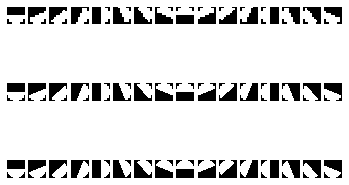

In [158]:
import matplotlib.pyplot as plt

masks = get_half_disks([10, 26, 50], 16)

for i in range(len(masks)):
    plt.subplot(3, 16, i + 1)
    plt.axis('off')
    plt.imshow(masks[i], cmap='gray')

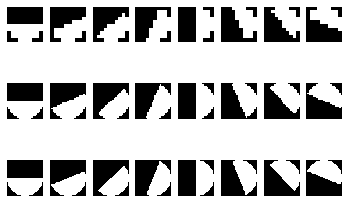

In [171]:
import matplotlib.pyplot as plt

masks = get_half_disks([10, 26, 50], 16)

left_masks, right_masks = [], []

left_masks.extend([*masks[0:8], *masks[16:24], *masks[32:40]])
right_masks.extend([*masks[8:16], *masks[24:32], *masks[40:48]])

for i in range(len(left_masks)):
    plt.subplot(3, 8, i + 1)
    plt.axis('off')
    plt.imshow(left_masks[i], cmap='gray')


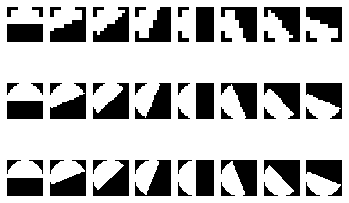

In [172]:
for i in range(len(right_masks)):
    plt.subplot(3, 8, i + 1)
    plt.axis('off')
    plt.imshow(right_masks[i], cmap='gray')

In [194]:
def get_gradient_map(img_map: List[List], bins) -> List[List]:

    chi_sqr_distances = []
    for i in range(0, int(len(masks)/2)):
        chi_sqr_dist = np.zeros(img_map.shape)
        for val in range(bins):
            bin_img = (img_map == val)
            bin_img = np.float32(bin_img)
            gi = cv2.filter2D(src=bin_img, ddepth=-1, kernel=np.float32(left_masks[i]))
            hi = cv2.filter2D(src=bin_img, ddepth=-1, kernel=np.float32(right_masks[i]))

            chi_sqr_dist += ((gi - hi) ** 2 )/2 * (gi + hi)
        chi_sqr_distances.append(chi_sqr_dist)

    chi_sqr_distances = np.array(chi_sqr_distances)
    return np.mean(chi_sqr_distances, axis=0)


In [195]:
res = get_gradient_map(img_gray, 64)

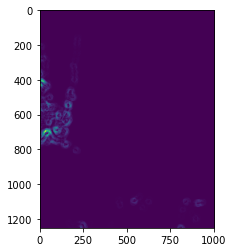

In [196]:
plt.imshow(res)

In [163]:
a = [1, 2, 3, 4, 5, 6, 7, 8]
a[0:8]

[1, 2, 3, 4, 5, 6, 7, 8]

In [174]:
np.sum(a)

36

In [153]:
for i in range(0, 9, 2):
    print(i)

0
2
4
6
8


In [184]:
import cv2

img = cv2.imread("/home/radha/b_map.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# bin_img = (img_gray == 126)

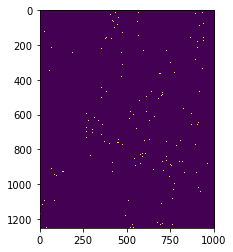

In [151]:
plt.imshow(bin_img)

In [176]:
chi_sqr_dist = np.zeros(bin_img.shape)
chi_sqr_dist


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[1, 2], [3, 4]])
a * b

array([[ 1,  4],
       [ 9, 16]])